<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1. Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p>

1. Implement the characteristic function of the conventional Heston model
\begin{align*}
	dS_t &=S_t \sqrt{V_t} dB_t, \quad d\langle W, B\rangle_t = \rho dt \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW_t, \quad V_0 \geq 0, S_0=1
\end{align*}
    
Denote by
$$ \Phi_{T}(z) = \mathbb E\left[ \exp\left( \mathrm i z \log S_T \right) \right]$$

2. Price Put options pricer using  Lewis inversion formula
$$ \mathbb E (K-S_T)^+ = K - \frac {\sqrt{S_0K}}{\pi } \int_{\mathbb R_+} \Re \left(e^{izk} \frac{\Phi_T(z-\frac{i}{2})}{z^2 + \frac 1 4 }\right) dz,$$
with $k=\log(S_0/K)$.

3. Plot implied vol surface (slice by slice for different maturity slices $T$ ranging from 0.02 to 1)

4. Set $\kappa=\eta=1/\epsilon$ and plot the atm skew as $\epsilon \to 0$ and comment.  


Calls are obtained by Put call parity (r=0).


To sanity check your code here are two value of references for prices of call.

Recall:



<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);">
    <strong>Theorem</strong>. (Characteristic function in Heston model)  For $v\in \mathbb R$,
$$
\mathbb E[\exp\left(iv\log S_T \right) |\mathcal F_t]  = \exp\left( iv\log S_t + \phi(T-t)  + \psi(T-t) V_t \right),
$$
with
\begin{align*}
\psi(t)&= \frac{\beta(v)-D(v)}{\eta^2}\frac{1-e^{-D(v)t}}{1-G(v)e^{-D(v)t}}\\
\phi(t)&= \frac{\theta}{\eta^2}\left((\beta(v)-D(v))t - 2 \log\left( \frac{G(v)e^{-D(v)t}-1}{G(v)-1} \right)\right)  \\
\beta(v) &= \kappa - iv \rho\eta, \quad  D(v)= \sqrt{\beta(v)^2  + \eta^2 v(i+v)}, \quad G(v) =\frac{\beta(v)-D(v)}{\beta(v)+ D(v)}.
\end{align*}
</div>
   

In [ ]:
kappa = 1.5768
theta = 0.0398*1.5768
V0 = 0.0175
rho = -0.5711
sigma = 0.5751

r = 0
K = 1.
s0 = 1.

ref_value_T1y = 0.05785155435  #See fang osterlee p15
ref_value_T10y = 0.22318945791474590  #See fang osterlee p15

eta = sigma

### 1. Implement the characteristic function

\begin{align*}
	dS_t &=S_t \sqrt{V_t} dB_t, \quad d\langle W, B\rangle_t = \rho dt \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW_t, \quad V_0 \geq 0, S_0=1
\end{align*}

In [ ]:
# import
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as si
from scipy.optimize import minimize
from scipy.integrate import quad

In [ ]:
def beta(v, kappa = kappa, rho = rho, eta = eta):
  return kappa-1j*v*rho*eta

def D(v, kappa = kappa, rho = rho, eta = eta):
  return np.sqrt(beta(v, kappa, rho, eta)**2 + eta**2 * v * (1j + v))

def G(v, kappa = kappa, rho = rho, eta = eta):
  return (beta(v, kappa, rho, eta)-D(v, kappa, rho, eta))/(beta(v, kappa, rho, eta)+D(v, kappa, rho, eta))

def phi(t, v, kappa = kappa, theta = theta, rho = rho, eta = eta):
  return theta/(eta**2) * ((beta(v, kappa, rho, eta)-D(v, kappa, rho, eta))*t -2 * np.log((G(v, kappa, rho, eta)*np.exp(-D(v, kappa, rho, eta)*t) -1)/(G(v, kappa, rho, eta)-1)))

def psi(t, v, kappa = kappa, rho = rho, eta = eta):
  return (beta(v, kappa, rho, eta)-D(v, kappa, rho, eta))/(eta**2) * (1-np.exp(-D(v, kappa, rho, eta)*t))/(1-G(v, kappa, rho, eta)*np.exp(-D(v, kappa, rho, eta)*t))

def heston_characteristic_function(v, T, t=0, st=s0, Vt=V0, kappa = kappa, rho = rho, eta = eta):
  return np.exp(1j*v*np.log(st)+phi(T-t, v, kappa, theta, rho, eta)+psi(T-t, v, kappa, rho, eta)*Vt)

### 2. Price Put options pricer using  Lewis inversion formula
$$ \mathbb E (K-S_T)^+ = K - \frac {\sqrt{S_0K}}{\pi } \int_{\mathbb R_+} \Re \left(e^{izk} \frac{\Phi_T(z-\frac{i}{2})}{z^2 + \frac 1 4 }\right) dz,$$
with $k=\log(S_0/K)$.


In [ ]:
def put(K, T = 1, S = s0, t=0, st=s0, Vt=V0, kappa = kappa, rho = rho, eta = eta):
  def f(z):
    k=np.log(S/K)
    return np.real(np.exp(1j*z*k)* (heston_characteristic_function(z-1j/2, T, t, st, Vt, kappa, rho, eta))/(z**2 + 1/4))

  z_vals = np.concatenate([np.linspace(0, 1, 200), np.linspace(1, 10, 200), np.linspace(10, 100, 200), np.linspace(100, 1000, 100)])
  f_vals = [f(z) for z in z_vals]
  result = np.trapz(f_vals, z_vals)
  return K-np.sqrt(S*K)/np.pi * result

In [ ]:
# test (comparaison avec les valeurs de références)
print(put(1, 1) - ref_value_T1y)
print(put(1, 10) - ref_value_T10y)

-7.634520389288024e-05
-6.661160396684296e-05


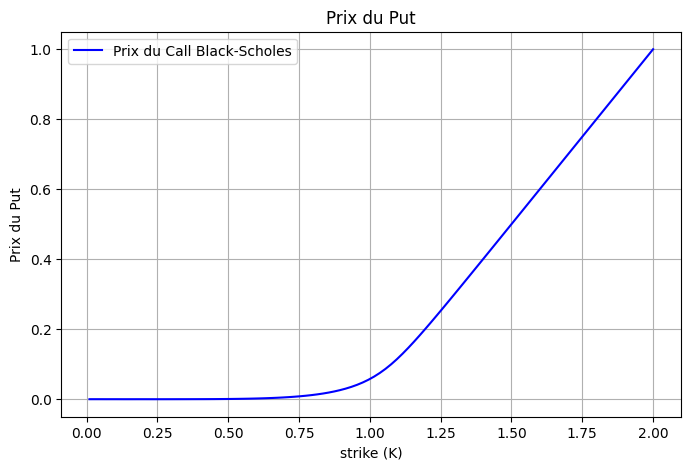

In [ ]:
plt.figure(figsize=(8, 5))
k_val = np.linspace(0.01, 2, 100)

plt.plot(k_val, [put(K, 1) for K in k_val], label='Prix du Put', color='b')
plt.xlabel('strike (K)')
plt.ylabel('Prix du Put')
plt.title('Prix du Put')
plt.legend()
plt.grid()
plt.show()

### **Commentaire**

Le graphe de la fonction K -> put(K) est cohérent et correspond à ce qui est attentu de l'option.

3. Plot implied vol surface (slice by slice for different maturity slices $T$ ranging from 0.02 to 1)

In [ ]:
def put_BS(T, K, sigma):
  d1 = (np.log(s0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  put_price = K * np.exp(-r * T) * si.norm.cdf(-d2) - s0 * si.norm.cdf(-d1)
  return put_price

def sigma(T, K, kappa = kappa, eta = eta):
  """fonction qui calcule la vol implicite du put heston"""
  p = put(T, K, kappa = kappa, eta = eta)
  def f(sigma):
    return (put_BS(T, K, sigma) - p)**2
  result = minimize(f, 0.2, bounds=[(1e-6, 3.0)], method='trust-constr', options={'xtol': 1e-8, 'gtol': 1e-8})
  return result.x[0]

In [ ]:
K_val = np.linspace(0.5, 2, 100)
sigma_val = [sigma(0.5, k) for k in K_val]

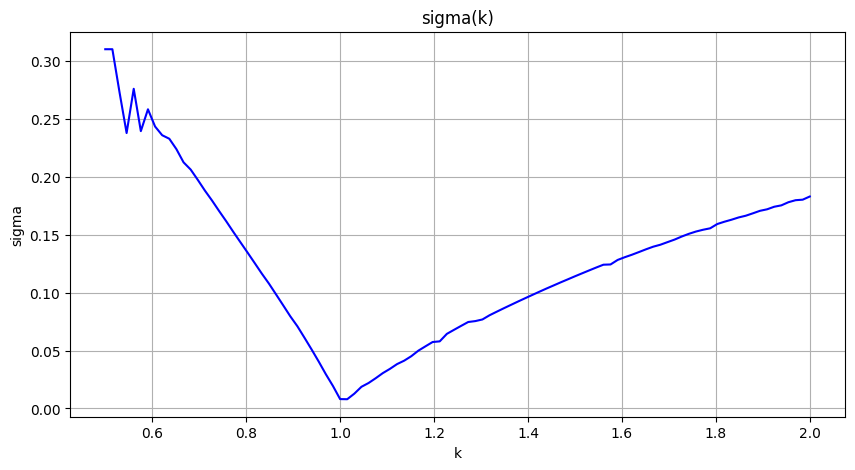

In [ ]:
# affichage
plt.figure(figsize=(10, 5))
plt.plot(K_val, sigma_val, linestyle='-', color='b')
plt.xlabel("k")
plt.ylabel("sigma")
plt.title("Volatilité implicite σ(K)")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


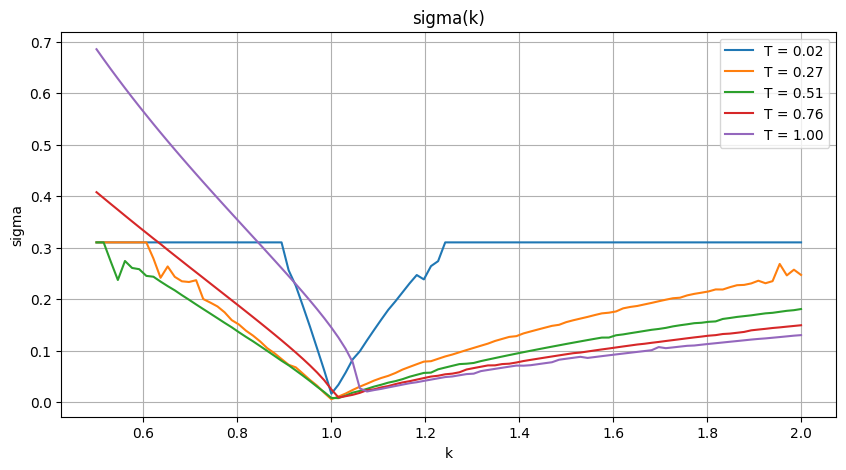

In [ ]:
plt.figure(figsize=(10, 5))
T_val = np.linspace(0.02, 1, 5)

for t in T_val:
    plt.plot(K_val, [sigma(t, k) for k in K_val], label=f"T = {t:.2f}")

plt.xlabel("k")
plt.ylabel("sigma")
plt.title("Volatilité implicite σ(K)")
plt.legend()
plt.grid(True)
plt.show()

4. Set $\kappa=\eta=1/\epsilon$ and plot the atm skew as $\epsilon \to 0$ and comment.  


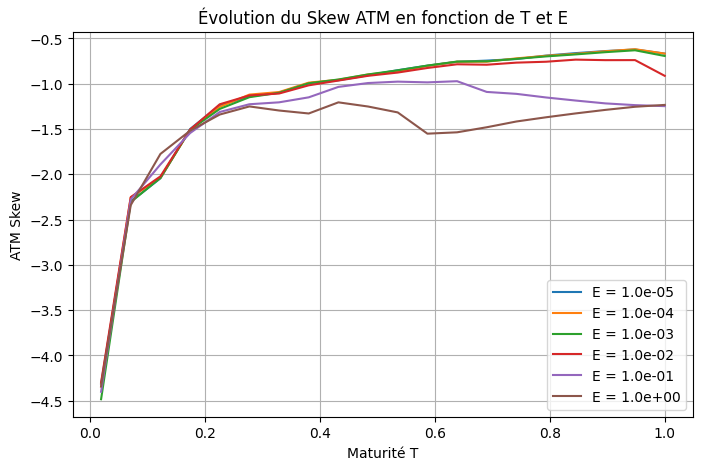

In [ ]:
def atm_skew(T, E):
  K_atm = s0
  eps = 1e-8
  K_0 = s0 * (1 - eps)
  K_1 = s0 * (1 + eps)

  sigma_0 = sigma(T, K_0, kappa=1/E, eta=1/E)
  sigma_1 = sigma(T, K_1, kappa=1/E, eta=1/E)

  return (sigma_1 - sigma_0) / (2 * eps * s0)

E_l = np.logspace(-5, 0, 6)
T_values = np.linspace(0.02, 1, 20)

plt.figure(figsize=(8, 5))
for E in E_l:
    skew_values = [atm_skew(T, E) for T in T_values]
    plt.plot(T_values, skew_values, label=f"E = {E:.1e}")

plt.xlabel("Maturité T")
plt.ylabel("ATM Skew")
plt.title("Évolution du Skew ATM en fonction de T et E")
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2. Volterra Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong>  </strong></p>

1. Do the same thing for Volterra Heston model:
Heston by a fractional one:
\begin{align*}
	dS_t &= S_t \sqrt{V_t} dB_t, \quad S_0=1,\\
	V_t &= V_0 + \int_0^t   K_{\epsilon}(t-s) \left(  ( \theta - \lambda V_s) ds +  \eta  \sqrt{V_s} dW_s \right),
\end{align*}
with $K_{\epsilon}(t) = {{(t +\epsilon)}^{H-1/2}}$

by implementing the Adam Scheme (or any other scheme) for the Riccati Volterra equation

2.  Plot the volatility surface for with $T=\{0.02, 0.04, 0.1, 0.25, 0.5, 1. \}$
and parameters
$$
 \lambda = 0, \quad    \rho=-0.7, \quad \theta=0.02, \quad \eta=0.3, \quad V_0=0.02, \quad H=0.1.
$$
3. For fixed $\epsilon =0$, make $H$ vary and plot the atm-skew between 1 week and 1 year for varying $H$ and comment
4. For fixed $H=0.01$ make $\epsilon$ vary and plot the atm-skew between 1 week and 1 year  and comment.
5. Which model seems more suited for the market? argue.


In [ ]:
# parametres
T, N = 1, 200

### 1. Volterra Heston

On définit les différentes fonctions et on fait la résolution.

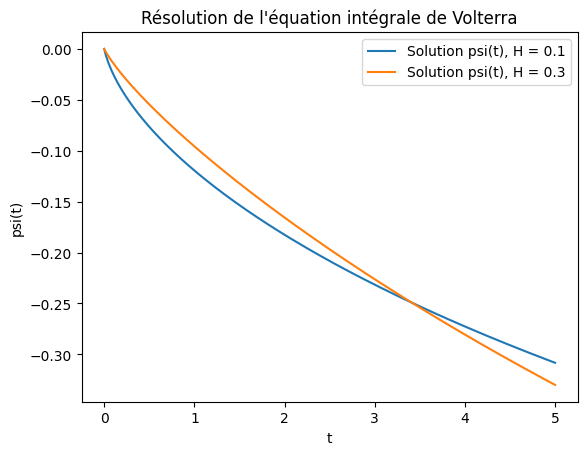

In [ ]:
def kernel(t, s, H=0.1, eps=0.01):
    return (t - s + eps)**(H - 1/2)

def F(psi, u, rho=-0.7, eta=0.3, lambd=0):
    psi = np.clip(psi, -1e4, 1e4)
    return 0.5 * (u * (u - 1 + rho * eta * psi)) - lambd * psi + (eta**2 / 2) * psi**2

def solve_volterra(T, N, H=0.1, eps=0.01, u=0.2, rho=-0.7, eta=0.3, lambd=0):
    t_vals = np.linspace(0, T, N)
    psi_vals = np.zeros(N, dtype=complex)
    dt = T / (N - 1)

    for i in range(1, N):
        t = t_vals[i]
        kernel_vals = kernel(t, t_vals[:i], H=H, eps=eps)
        F_vals = F(psi_vals[:i], u, rho, eta, lambd)

        integral = np.dot(kernel_vals, F_vals) * dt
        psi_vals[i] = integral

    return t_vals, psi_vals


# tests
t_vals, psi_vals = solve_volterra(5, 300, 0.1)
plt.plot(t_vals, np.real(psi_vals), label="Solution psi(t), H = 0.1")

t_vals, psi_vals = solve_volterra(5, 300, 0.3)
plt.plot(t_vals, np.real(psi_vals), label="Solution psi(t), H = 0.3")

plt.xlabel("t")
plt.ylabel("psi(t)")
plt.title("Résolution de l'équation intégrale de Volterra")
plt.legend()
plt.show()

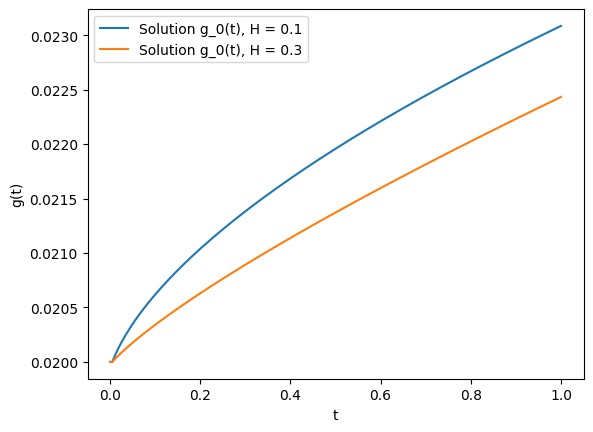

In [ ]:
def g(t_vals, v0, H, lmd, theta):
  N = len(t_vals)
  g_vals = np.zeros(N)
  g_vals[0] = v0
  for i in range(1, N):
    t = t_vals[i]
    integral = np.trapz([kernel(t, t_vals[j], H) * lmd * theta for j in range(i)], t_vals[:i])
    g_vals[i] = integral + v0
  return g_vals

# test
t_vals, psi_vals = solve_volterra(T, N)
g_vals = g(t_vals, v0 = 0.02, H = 0.1, lmd = 0.1, theta = 0.02)
plt.plot(t_vals, g_vals, label="Solution g_0(t), H = 0.1")
g_vals = g(t_vals, v0 = 0.02, H = 0.3, lmd = 0.1, theta = 0.02)
plt.plot(t_vals, g_vals, label="Solution g_0(t), H = 0.3")
plt.xlabel("t")
plt.ylabel("g(t)")
plt.title("")
plt.legend()
plt.show()

In [ ]:
def safe_exp(x, limit=100):
  """fonction qui permet d'éviter l'explosion de l'exp"""
  x = np.asarray(x)
  return np.exp(np.clip(x, -limit, limit))

def characteristic_function_volterra_heston(u, T, H=0.1, eps=0.01, s0=1, rho=-0.7, eta=0.3, lmd=0, v0=0.02, theta=0.02):
  """"""
  u = 1j * np.asarray(u)
  t_vals, psi_vals = solve_volterra(T, N, H, eps, u, rho, eta, lmd)

  g_vals = g(t_vals, v0, H, lmd, theta)
  integral = np.trapz(F(psi_vals, u, rho, eta, lmd) * g_vals, t_vals)

  return safe_exp(u * np.log(s0) + integral)

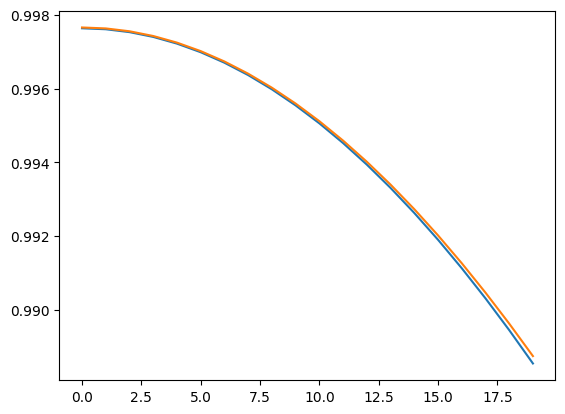

In [ ]:
# test
characteristic_function_volterra_heston_vals = np.real([characteristic_function_volterra_heston(u - 0.5 * 1j, 1) for u in np.linspace(0, 1, 20)])
plt.plot(characteristic_function_volterra_heston_vals)
characteristic_function_volterra_heston_vals = np.real([characteristic_function_volterra_heston(u - 0.5 * 1j, 1, 1/56) for u in np.linspace(0, 1, 20)])
plt.plot(characteristic_function_volterra_heston_vals)
plt.show()

In [ ]:
# test
characteristic_function_volterra_heston(0, 1)

(1+0j)

In [ ]:
def f2(z, K, T, H=0.1, eps=0):
  z = np.asarray(z)
  exponent = 1j * z * np.log(s0 / K)
  char_func = characteristic_function_volterra_heston(z - 0.5 * 1j, T, H, eps)
  return np.real(safe_exp(exponent) * char_func) / (z**2 + 0.25)

def put_volterra_heston(T, K, H=0.1, eps=0.01):
  z_vals = np.concatenate([np.linspace(0, 1, 100), np.linspace(1, 10, 100), np.linspace(10, 100, 100)])
  f_vals = [f2(z, K, T, H, eps) for z in z_vals]
  result = np.trapz(f_vals, z_vals)
  return K - (1 / np.pi) * (s0 * K)**(1 / 2) * result

In [ ]:
# test
print(put_volterra_heston(1, 1, 0.1, 0.01))

0.040024947192077165


In [ ]:
# test
print(put_volterra_heston(0.1, 1, 0.1, 0.01))

0.014396432274365378


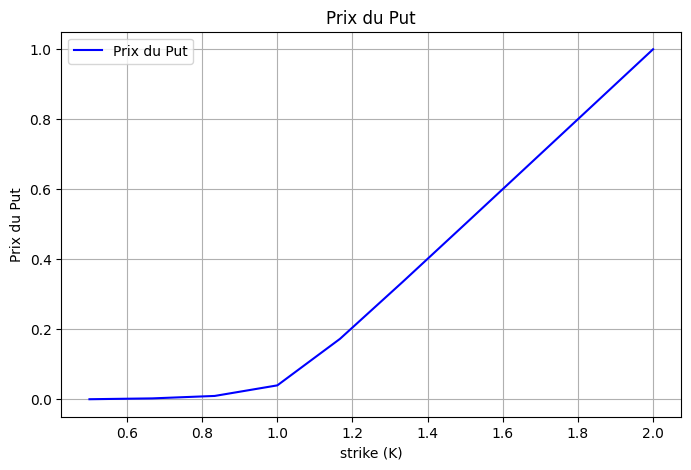

In [ ]:
k_val = np.linspace(0.5, 2, 10)
plt.figure(figsize=(8, 5))

plt.plot(k_val, [put_volterra_heston(1, K) for K in k_val], label='Prix du Put', color='b')
plt.xlabel('strike (K)')
plt.ylabel('Prix du Put')
plt.title('Prix du Put')
plt.legend()
plt.grid()
plt.show()
plt.show()

## 2. Plot the volatility surface

*2*.  Plot the volatility surface for with $T=\{0.02, 0.04, 0.1, 0.25, 0.5, 1. \}$
and parameters
$$ \lambda = 0, \quad    \rho=-0.7, \quad \theta=0.02, \quad \eta=0.3, \quad V_0=0.02, \quad H=0.1.$$

In [ ]:
def sigma2(T, K, H = 0.1, eps = 0.01):
  p = put_volterra_heston(T, K, H, eps)
  def f(sigma):
    return (put_BS(T, K, sigma) - p)**2

  result = minimize(f, 0.2, bounds=[(1e-5, 3.0)], method='trust-constr', options={'xtol': 1e-8, 'gtol': 1e-8})
  return result.x[0]

In [ ]:
# test
sigma2(0.1, 1.2)

0.177170369911831

In [ ]:
T_val = [0.02, 0.04, 0.1, 0.25, 0.5, 1]

K_val = np.linspace(0.5, 1.5, 20)
sigma_l = []
for t in T_val:
  print("t : " + str(t))
  sigma_l.append([sigma2(t, k) for k in K_val])

t : 0.02
t : 0.04
t : 0.1
t : 0.25
t : 0.5
t : 1


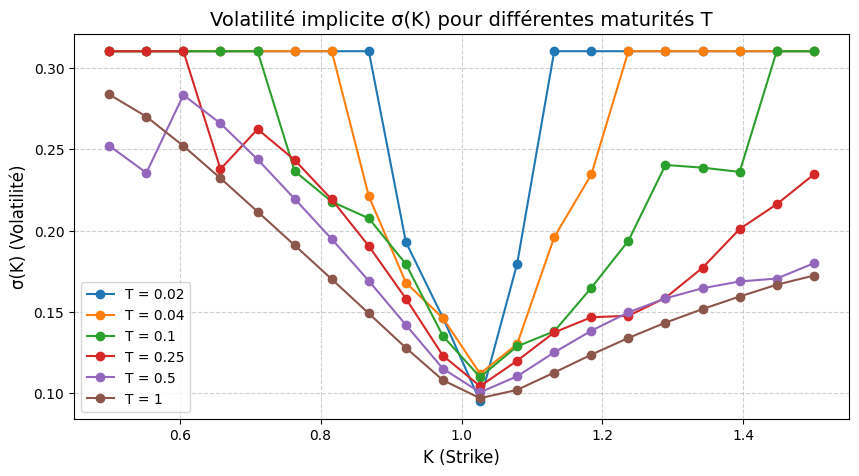

In [ ]:
plt.figure(figsize=(10, 5))

for i, t in enumerate(T_val):
  plt.plot(K_val, sigma_l[i], label=f"T = {t}", marker="o", linestyle="-")

plt.title("Volatilité implicite σ(K) pour différentes maturités T", fontsize=14)
plt.xlabel("K (Strike)", fontsize=12)
plt.ylabel("σ(K) (Volatilité)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

## 3. $\epsilon =0$, H vary

3. For fixed $\epsilon =0$, make $H$ vary and plot the atm-skew between 1 week and 1 year for varying $H$ and comment


In [ ]:
def atm_skew2(T, H = 0.1, eps = 0.01):
  K_atm = s0
  d = 10e-4
  K_0 = s0 * (1 - d)
  K_1 = s0 * (1 + d)

  sigma_0 = sigma2(T, K_0, H, eps)
  sigma_1 = sigma2(T, K_1, H, eps)
  return (sigma_1 - sigma_0) / (2*d*s0)

In [ ]:
T_values = [1/52, 0.1, 0.5, 1]
h_list = np.linspace(0.01, 0.9, 5)

skew_results1 = {}

for T in T_values:
  skew_results1[T] = [atm_skew2(T, H, 0) for H in h_list]

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


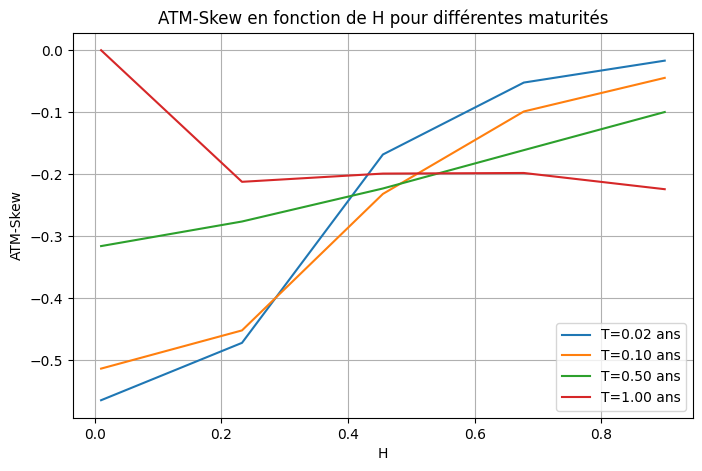

In [ ]:
plt.figure(figsize=(8, 5))
for T in T_values:
  plt.plot(h_list, skew_results1[T], label=f"T={T:.2f} ans")

plt.xlabel("H")
plt.ylabel("ATM-Skew")
plt.title("ATM-Skew en fonction de H pour différentes maturités")
plt.legend()
plt.grid()
plt.show()

## 4. H=0.01, epsilon vary

4. For fixed $H=0.01$ make $\epsilon$ vary and plot the atm-skew between 1 week and 1 year  and comment.

In [ ]:
T_values = [1/52, 0.1, 0.5, 1]
eps_list = np.linspace(0.001, 0.1, 5)

skew_results2 = {}

for T in T_values:
    skew_results2[T] = [atm_skew2(T, 0.01, eps) for eps in eps_list]

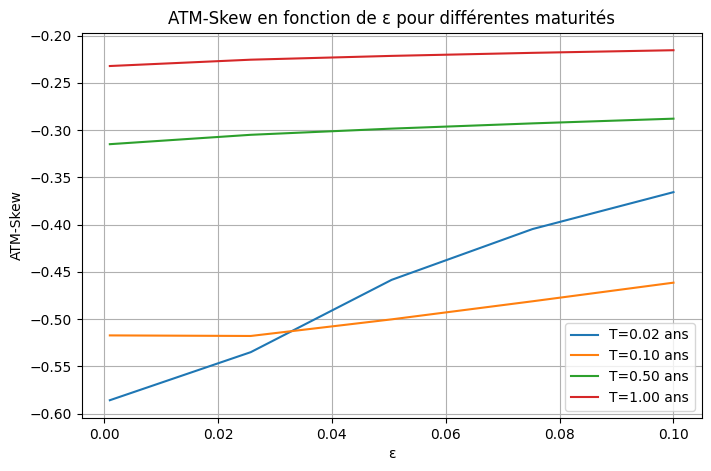

In [ ]:
plt.figure(figsize=(8, 5))
for T in T_values:
    plt.plot(eps_list, skew_results2[T], label=f"T={T:.2f} ans")

plt.xlabel("ε")
plt.ylabel("ATM-Skew")
plt.title("ATM-Skew en fonction de ε pour différentes maturités")
plt.legend()
plt.grid()
plt.show()